# 1. Data Preparation

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch

x, t = make_moons(n_samples=100, noise=0.3, random_state=0)

# 不要搞反了train_test_split的返回值
# x_train, t_train, x_val, t_val = train_test_split(x, t, test_size=0.2, random_state=13)
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.2, random_state=13)
print(x_train.shape, x_val.shape, t_train.shape, t_val.shape)

# 数据标准化：
sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_val = sc.transform(x_val)

x_train_tensor = torch.from_numpy(x_train).float()
t_train_tensor = torch.from_numpy(t_train.reshape(-1, 1)).float()
x_val_tensor = torch.from_numpy(x_val).float()
t_val_tensor = torch.from_numpy(t_val.reshape(-1, 1)).float()
print(x_train_tensor.shape, t_train_tensor.shape, x_val_tensor.shape, t_val_tensor.shape)

batch_size = 16
train_dataset = TensorDataset(x_train_tensor, t_train_tensor)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, t_val_tensor)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

(80, 2) (20, 2) (80,) (20,)
torch.Size([80, 2]) torch.Size([80, 1]) torch.Size([20, 2]) torch.Size([20, 1])


# 2. Model Configuration

In [2]:
from torch import nn, optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = nn.Sequential()
model.add_module("linear", nn.Linear(2, 1))
model.to(device)

loss_fn = nn.BCEWithLogitsLoss()

lr = 0.1
optimizer = optim.SGD(params=model.parameters(), lr=lr)

# 3. Model Training

In [ ]:
import numpy as np

n_epochs = 100

train_losses = []
val_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss_batch = []
    for x_batch, t_batch in train_dataloader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        y_batch = model(x_batch)
        train_loss = loss_fn(y_batch, t_batch)
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_batch.append(train_loss.item())
    train_losses.append(np.mean(train_loss_batch))  # 取平均值
    
    model.eval()
    val_loss_batch = []
    for x_batch, t_batch in val_dataloader:
        x_batch = x_batch.to(device)
        t_batch = t_batch.to(device)
        with torch.no_grad():
            y_batch = model(x_batch)
            val_loss = loss_fn(y_batch, t_batch)
        val_loss_batch.append(val_loss.item())
    val_losses.append(np.mean(val_loss_batch))


In [6]:
print(model.state_dict())

# OrderedDict({'linear.weight': tensor([[ 1.1806, -1.8693]]), 'linear.bias': tensor([-0.0591])})

OrderedDict({'linear.weight': tensor([[ 1.1825, -1.8723]]), 'linear.bias': tensor([-0.0583])})


# Loss Curve

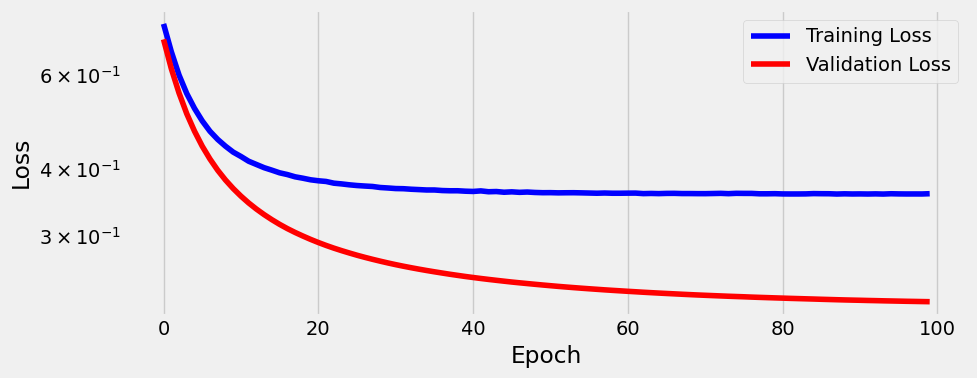

In [8]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Training Loss", c="b")
plt.plot(val_losses, label="Validation Loss", c="r")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()